In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import warnings
import random
import pickle
import re
import os
import os.path as osp
import copy
import itertools

from tqdm.notebook import tqdm

# Download Homstrad

In [2]:
%%bash

if [ ! -d homstrad_db ]; then
    mkdir homstrad_db
    curl https://mizuguchilab.org/homstrad/data/homstrad_with_PDB_2022_Aug_1.tar.gz | tar -xz -C homstrad_db
    
    # Fix the igV PDB, because the chain order is wrong (corrects only the first two)
    mv homstrad_db/igV/igV-sup.pdb homstrad_db/igV/igV-sup.pdb.orig

    echo \
    'REMARK The domains in this file are:
    REMARK    1tvdb   chain    H
    REMARK    1qfpa   chain    G
    REMARK    1b88a   chain    A
    REMARK    1cd8    chain    A
    REMARK    3cd4    chain    A
    REMARK    1neu    chain    A
    REMARK    1hnga   chain    A
    REMARK    1cid1   chain    A
    REMARK    1hnf    chain    A' > homstrad_db/igV/igV-sup.pdb
    cat homstrad_db/igV/igV-sup.pdb.orig >> homstrad_db/igV/igV-sup.pdb
fi

In [3]:
%%bash
mkdir -p out/pdbs

### Homstradt parsing gotchas
- the chain order in PDBs doesn't always match the order in the alignment files (see Remarks in some PDB files for order)
- the chain in the PDB can be a number (not only A,B,C,...)
- there can be multiple chains with the same label (e.g. in the case with more than 26 chains)

# Copy structures into single PDBs

In [4]:
explicit_mapping_cnt, implicit_mapping_cnt = 0, 0
for family in tqdm(os.listdir('homstrad_db/')):
    os.makedirs(f'out/pdbs/{family}', exist_ok=True)
    
    # Parse family member names
    with open(f'homstrad_db/{family}/{family}.ali') as file:
        fam_members = []
        for line in file:
            if line.startswith('>'):
                name = line[4:-1]
                fam_members.append(name)
                assert len(name) != 0, f'{fam_members[-1]} is to short'
        
    
    # Split family PDB
    chains = ''  # 
    with open(f'homstrad_db/{family}/{family}-sup.pdb') as file:
        single_pdbs = [[] for _ in fam_members]
        last_chain = None
        i = -1
        for line in file:
            if line.startswith('ATOM'):
                chain = line[21:22]
                if chain != last_chain:
                    i += 1
                    last_chain = chain
                    chains += chain
                assert i >= 0
                single_pdbs[i].append(line)

    assert len(chains) == len(single_pdbs)
                
    # Select family members:
    q_name, t_name = fam_members[0], fam_members[-1]  # first and last
                
    # Find mapping between alignment and pdb file
    with open(f'homstrad_db/{family}/{family}-sup.pdb') as file:
        pdb_txt = file.read()
    # mapping is contained in remark section of pdb file
    if 'REMARK The domains in this file are:' in pdb_txt:
        lines = pdb_txt.splitlines()
        idx = lines.index([line for line in lines if line.startswith('REMARK The domains in this file are:')][0])
        id2chain = {}
        for line in lines[idx+1:idx+1+len(fam_members)]:
            _, name, chain, chain_name = line.split()
            assert chain == 'chain'
            id2chain[name] = chain_name
        
        q_pdb_idx = chains.index(id2chain[q_name])
        t_pdb_idx = chains.index(id2chain[t_name])
        q_pdb = single_pdbs[q_pdb_idx]
        t_pdb = single_pdbs[t_pdb_idx]
        explicit_mapping_cnt += 1
                
    else:  # pdb file has same order as alignment file
        q_pdb, t_pdb = single_pdbs[0], single_pdbs[-1]
        implicit_mapping_cnt += 1
    
    # Write selected pdbs
    for lines, name in zip((q_pdb, t_pdb), (q_name, t_name)):
        assert len(lines) > 0
        with open(f'out/pdbs/{family}/{name}.pdb', 'w') as pdb_file:
            pdb_file.writelines(lines)
    with open(f'out/pdbs/{family}/names.txt', 'w') as file:
        file.write(f'{q_name} {t_name}\n')
        
explicit_mapping_cnt, implicit_mapping_cnt

  0%|          | 0/1032 [00:00<?, ?it/s]

(106, 926)

# Generate Alignments

## Foldseek

In [5]:
%%bash

date
FOLDSEEK=../../foldseek/build/src/foldseek

fake_pref() {
    QDB="$1"
    TDB="$2"
    RES="$3"
    
    # create link to data file which contains a list of all targets that should be aligned
    ln -s "${TDB}.index" "${RES}"
    # create new index repeatedly pointing to same entry
    INDEX_SIZE="$(echo $(wc -c < "${TDB}.index"))"
    awk -v size=$INDEX_SIZE '{ print $1"\t0\t"size; }' "${QDB}.index" > "${RES}.index"
    # create dbtype (7)
    awk 'BEGIN { printf("%c%c%c%c",7,0,0,0); exit; }' > "${RES}.dbtype"
}

for fam in out/pdbs/*
do
    mkdir -p $fam/foldseek_tmp
    rm -f $fam/foldseek_tmp/*
    rm -f out/result.tsv
    rm -f $fam/foldseek.aln*
    
    $FOLDSEEK createdb $fam out/db >> $fam/foldseek_tmp/foldseek.log

    rm -f out/fakeprefdb*
    fake_pref out/db out/db out/fakeprefdb
    ln -sf db.index out/fakeprefdb

    #   --sub-mat mat3di_bias10.out
    $FOLDSEEK structurealign out/db out/db out/fakeprefdb out/result -e 100000 -a >> $fam/foldseek_tmp/foldseek.log
    $FOLDSEEK convertalis out/db out/db out/result out/result.tsv --format-output "query,target,qstart,tstart,qaln,taln,evalue,bits" >> $fam/foldseek_tmp/foldseek.log
    awk '{split($1, name1, "."); split($2, name2, "."); print name1[1], name2[1], $3-1, $4-1, $5, $6}' out/result.tsv > $fam/foldseek.aln
done
date

Do 1. Sep 18:58:00 CEST 2022
Do 1. Sep 19:04:37 CEST 2022


## MMseqs

In [6]:
%%bash

date
FOLDSEEK=../../foldseek/build/src/foldseek

fake_pref() {
    QDB="$1"
    TDB="$2"
    RES="$3"
    
    # create link to data file which contains a list of all targets that should be aligned
    ln -s "${TDB}.index" "${RES}"
    # create new index repeatedly pointing to same entry
    INDEX_SIZE="$(echo $(wc -c < "${TDB}.index"))"
    awk -v size=$INDEX_SIZE '{ print $1"\t0\t"size; }' "${QDB}.index" > "${RES}.index"
    # create dbtype (7)
    awk 'BEGIN { printf("%c%c%c%c",7,0,0,0); exit; }' > "${RES}.dbtype"
}

for fam in out/pdbs/*
do
    mkdir -p $fam/mmseqs_tmp
    rm -f $fam/mmseqs_tmp/*
    rm -f out/result.tsv
    rm -f $fam/mmseqs.aln*
    
    $FOLDSEEK createdb $fam out/db >> $fam/mmseqs_tmp/mmseqs.log

    rm -f out/fakeprefdb*
    fake_pref out/db out/db out/fakeprefdb
    ln -sf db.index out/fakeprefdb

    $FOLDSEEK align out/db out/db out/fakeprefdb out/result -e 100000 -a >> $fam/mmseqs_tmp/mmseqs.log
    $FOLDSEEK convertalis out/db out/db out/result out/result.tsv --format-output "query,target,qstart,tstart,qaln,taln,evalue,bits" >> $fam/mmseqs_tmp/mmseqs.log
    awk '{split($1, name1, "."); split($2, name2, "."); print name1[1], name2[1], $3-1, $4-1, $5, $6}' out/result.tsv > $fam/mmseqs.aln
done
date

Do 1. Sep 19:04:37 CEST 2022
Do 1. Sep 19:11:56 CEST 2022


## TM-align

In [7]:
%%bash
TMALIGN=../tmalign_benchmark/tmalign/TMalign

date
for fam in out/pdbs/*
do
    mkdir -p $fam/tmalign_tmp
    rm -f $fam/tmalign_tmp/*
    rm -f $fam/tmalign.aln*
    name1="$fam/"$(awk '{print $1}' $fam/names.txt)".pdb"
    name2="$fam/"$(awk '{print $2}' $fam/names.txt)".pdb"
    n1=$(basename $name1 .pdb)
    n2=$(basename $name2 .pdb)

    $TMALIGN $name1 $name2 \
        | tee -a $fam/tmalign_tmp/tmalign.out \
        | sed -n '19p;21p;' | sed -z "s/\n/ /g" \
        | awk -v name1=$n1 -v name2=$n2 '{print name1, name2, 0, 0, $1, $2}' \
        >> $fam/tmalign.aln

done
date

Do 1. Sep 19:11:57 CEST 2022
Do 1. Sep 19:16:03 CEST 2022


## TM-align fast

In [8]:
%%bash
TMALIGN=../tmalign_benchmark/tmalign/TMalign

date
for fam in out/pdbs/*
do
    mkdir -p $fam/tmalignfast_tmp
    rm -f $fam/tmalignfast.aln
    rm -f $fam/tmalignfast_tmp/*
    
    name1="$fam/"$(awk '{print $1}' $fam/names.txt)".pdb"
    name2="$fam/"$(awk '{print $2}' $fam/names.txt)".pdb"    
    n1=$(basename $name1 .pdb)
    n2=$(basename $name2 .pdb)
    
    $TMALIGN $name1 $name2 -fast \
        | tee -a $fam/tmalignfast_tmp/tmalign.out \
        | sed -n '19p;21p;' | sed -z "s/\n/ /g" \
        | awk -v name1=$n1 -v name2=$n2 '{print name1, name2, 0, 0, $1, $2}' \
        >> $fam/tmalignfast.aln
done
date

Do 1. Sep 19:16:03 CEST 2022
Do 1. Sep 19:17:44 CEST 2022


## DALI

In [9]:
%%bash
if [ ! -d out/DaliLite.v5 ]; then
    curl http://ekhidna2.biocenter.helsinki.fi/dali/DaliLite.v5.tar.gz | tar -xz -C out
    
    cd out/DaliLite.v5/bin
    make clean
    make
fi

In [123]:
%%writefile out/unalign_lowerletters.py

"""
In the DALI alignment output format, lowercase letters indicate that there is
no alignment between them.
This script inserts a gap in each sequence such that other programs interpret
the alignment correctly.
"""
import sys

aln1, aln2 = open(sys.argv[1]).read().splitlines()

assert len(aln1) == len(aln2)
res1, res2 = '', ''
buffer1, buffer2 = '', ''
for c1, c2 in zip(aln1, aln2):
    if c1.islower() and c2.islower():
        #res1 += '-' + c1
        #res2 += c2 + '-'
        buffer1 += c1
        buffer2 += c2
    else:
        if buffer1:
            res1 += buffer1 + ('-' * len(buffer1))
            res2 += ('-' * len(buffer2)) + buffer2
            buffer1, buffer2 = '', ''
        res1 += c1
        res2 += c2
                     
if buffer1:
    res1 += buffer1 + ('-' * len(buffer1))
    res2 += ('-' * len(buffer2)) + buffer2
    buffer1, buffer2 = '', ''
        
print(res1, res2)

Overwriting out/unalign_lowerletters.py


In [125]:
%%bash

DALI=./out/DaliLite.v5/bin

date
for fam in out/pdbs/*
do    
    name1="$fam/"$(awk '{print $1}' $fam/names.txt)".pdb"
    name2="$fam/"$(awk '{print $2}' $fam/names.txt)".pdb"
    rm -f $fam/dali.aln*
    mkdir -p $fam/dali_tmp
    rm -f $fam/dali_tmp/*
    
    # Convert PDBs into Dali's format    
    $DALI/import.pl --pdbfile $name1 --pdbid aaaa --dat $fam/dali_tmp/ --clean &> $fam/dali_tmp/dali.log
    $DALI/import.pl --pdbfile $name2 --pdbid bbbb --dat $fam/dali_tmp/ --clean &>> $fam/dali_tmp/dali.log

    # Alignment
    id1=$(find $fam/dali_tmp/ -name "aaaa?.dat" -exec basename {} .dat \;)
    id2=$(find $fam/dali_tmp/ -name "bbbb?.dat" -exec basename {} .dat \;)
    $DALI/dali.pl --cd1 $id1 --cd2 $id2 --dat1 $fam/dali_tmp/ --dat2 $fam/dali_tmp/ --clean --outfmt "summary,alignments" &>> $fam/dali_tmp/dali.log

    # Extract alignment
    awk '/^Query/{print $2}' $id1.txt | sed -z "s/\n//g" > $fam/dali_tmp/tmp_aln.txt
    echo '' >> $fam/dali_tmp/tmp_aln.txt
    awk '/^Sbjct/{print $2}' $id1.txt | sed -z "s/\n//g" >> $fam/dali_tmp/tmp_aln.txt
    mv $id1.txt $fam/dali_tmp/result.txt

    # Note: lower-case letters in the alignment are unaligned!
    # Reformat output
    n1=$(basename $name1 .pdb)
    n2=$(basename $name2 .pdb)
    python3 out/unalign_lowerletters.py $fam/dali_tmp/tmp_aln.txt \
    | awk -v name1=$n1 -v name2=$n2 '{print name1, name2, 0, 0, $1, $2}' \
    >> $fam/dali.aln
    
done
date

Di 6. Sep 15:52:45 CEST 2022
Di 6. Sep 16:36:58 CEST 2022


Traceback (most recent call last):
  File "/home/michel/ownCloud/project1/foldseek/foldseek-analysis/homstrad_benchmark/out/unalign_lowerletters.py", line 10, in <module>
    aln1, aln2 = open(sys.argv[1]).read().splitlines()
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/home/michel/ownCloud/project1/foldseek/foldseek-analysis/homstrad_benchmark/out/unalign_lowerletters.py", line 10, in <module>
    aln1, aln2 = open(sys.argv[1]).read().splitlines()
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/home/michel/ownCloud/project1/foldseek/foldseek-analysis/homstrad_benchmark/out/unalign_lowerletters.py", line 10, in <module>
    aln1, aln2 = open(sys.argv[1]).read().splitlines()
ValueError: not enough values to unpack (expected 2, got 1)
Traceback (most recent call last):
  File "/home/michel/ownCloud/project1/foldseek/foldseek-analysis/homstrad_benchmark/out/unalign_lowerlette

## CE

In [42]:
%%bash
date
for fam in out/pdbs/*
do
    rm -f out/ce/targets/*
    rm -f out/ce/output*
    rm -f out/ce/query.txt
    mkdir -p $fam/ce_tmp
    rm -f $fam/ce_tmp/*
    rm -f $fam/ce.aln

    name1="$fam/"$(awk '{print $1}' $fam/names.txt)".pdb"
    name2="$fam/"$(awk '{print $2}' $fam/names.txt)".pdb"
    n1=$(basename $name1 .pdb)
    n2=$(basename $name2 .pdb)

    echo $name1 > out/ce/query.txt
    mkdir -p out/ce/targets
    cp $name2 out/ce/targets
    java -jar res/ce.jar out/ce/query.txt out/ce/targets out/ce/output_ &> /dev/null
    
    
    cat out/ce/output_*.result >> $fam/ce_tmp/ce.log
    sed '0,/^Alignment length/d' out/ce/output_*.result \
        | awk -v name1=$n1 -v name2=$n2 \
            'BEGIN {qstart=-1;tstart=-1} 
             /^Chain 1:/ && qstart==-1 {qstart=$3-1}
             /^Chain 1:/ {qaln=qaln$4}
             /^Chain 2:/ && tstart==-1 {tstart=$3-1}
             /^Chain 2:/ {taln=taln$4}
             END { if (!(qstart==-1)) {print name1,name2,qstart,tstart,qaln,taln}}' \
        > $fam/ce.aln
    
done
date

Fr 2. Sep 07:37:51 CEST 2022
Fr 2. Sep 07:37:54 CEST 2022


## CLE-SW

In [13]:
%%bash
if [ ! -d out/ssw ]; then
    git clone https://github.com/mengyao/Complete-Striped-Smith-Waterman-Library.git out/ssw
    cd out/ssw/src
    make
fi

if [ ! -d out/PDB_Tool ]; then
    git clone https://github.com/realbigws/PDB_Tool.git out/PDB_Tool
    cd out/PDB_Tool/source_code/
    make
fi

In [14]:
%%bash
mkdir -p out/cle
date
for fam in out/pdbs/*
do    
    name1="$fam/"$(awk '{print $1}' $fam/names.txt)".pdb"
    name2="$fam/"$(awk '{print $2}' $fam/names.txt)".pdb"
    n1=$(basename $name1 .pdb)
    n2=$(basename $name2 .pdb)
    fn=$(basename $fam)  # family name without path
    pdb=homstrad_db/$fn/$fn-sup.pdb  # family pdb
    mkdir -p $fam/cle_tmp
    rm -f $fam/cle_tmp/*
    rm -f $fam/cle.aln*
    
    if [[ "$fn" == 'prc' ]]; then
        touch $fam/cle.aln
        continue
    fi

    firstchain=$(awk '/^ATOM/' $name1 | head -n 1 | cut -c 22)
    lastchain=$(awk '/^ATOM/' $name2 | head -n 1 | cut -c 22)
    # check if length == 1
    # CLE hangs when used on the splitted PDBs
    out/PDB_Tool/PDB_Tool -i $pdb -r $firstchain -F 1 -o out/cle/aaaa.txt
    out/PDB_Tool/PDB_Tool -i $pdb -r $lastchain -F 1 -o out/cle/bbbb.txt
    out/ssw/src/ssw_test -o 100 -e 10 -a ../scopbenchmark/scripts/cle.shen.mat -p -f 1 -c out/cle/bbbb.cle out/cle/aaaa.cle 2> /dev/null \
        | tee -a $fam/cle_tmp/results.txt \
        | awk -v name1=$n1 -v name2=$n2 \
            'BEGIN {qstart=-1;tstart=-1} 
             /^Query:/ && qstart==-1 {qstart=$2-1}
             /^Query:/ {qaln=qaln$3}
             /^Target:/ && tstart==-1 {tstart=$2-1}
             /^Target:/ {taln=taln$3}
             END { if (!(qstart==-1)) {print name1,name2,qstart,tstart,qaln,taln}}' \
        > $fam/cle.aln 2>> out/cle.log
    echo $fam >> out/cle.list
done
date

Do 1. Sep 20:59:28 CEST 2022
Do 1. Sep 21:00:46 CEST 2022


# Parse alignments

In [15]:
def pairs_from_aln(start1, aln1, start2, aln2):
    i1, i2 = start1, start2
    pairs = []
    for letter1, letter2 in zip(aln1, aln2):
        if letter1 not in ('-', '/') and letter2 not in ('-', '/'):
            pairs.append((i1, i2))
        if letter1 not in ('-', '/'):
            i1 += 1
        if letter2 not in ('-', '/'):
            i2 += 1
    return pairs

In [16]:
def parse_homstrad_ali(path):
    with open(path) as file:
        lines = file.readlines()
    aln = []
    
    while True:
        line = lines.pop(0)
        
        if line.startswith('C;'):
            pass
        elif not line.rstrip('\n'):
            pass
        elif line.startswith('>'):
            name = line[4:-1]
            aln.append((name, []))
            info_line = lines.pop(0)
            assert info_line.startswith('structure'), info_line + ' ' + path
        else:
            aln[-1][1].append(line)
            
        if not lines:
            break

    res = []
    for name, lst in aln:
        assert lst
        assert lst[-1].rstrip('\n').endswith('*'), f'{name} might be wrong'
        res.append((name, ''.join(line.rstrip('*\n') for line in lst)))
    return res

def parse_test_ali(path):
    aln = {}
    for name1, name2, start1, start2, qaln, taln in (i.split()[:6] for i in open(path)):
        if name1 != name2:
            aln[(name1, name2)] = (int(start1), qaln, int(start2), taln)
    return aln

In [84]:
def check_alignment(fam_name_fn, family):
    aln = parse_test_ali(fam_name_fn(family))
    ref_aln = parse_homstrad_ali(f'homstrad_db/{family}/{family}.ali')

    res = []
    log = ''
    
    name1, ref_aln1 = ref_aln[0]
    name2, ref_aln2 = ref_aln[-1]

    if (name1, name2) not in aln:
        res.append([name1, name2, None, None, family, None])
        return res
    start1, aln1, start2, aln2 = predicted_aln = aln[(name1, name2)]

    ref_pairs = pairs_from_aln(0, ref_aln1, 0, ref_aln2)  # here
    pairs = pairs_from_aln(start1, aln1, start2, aln2)

    sensitivity = len([p for p in ref_pairs if p in pairs]) / len(ref_pairs)
    accuracy = len([p for p in pairs if p in ref_pairs]) / len(pairs)

    res.append([name1, name2, sensitivity, accuracy, family, predicted_aln])

    # Logging
    correct_pairs = [p for p in pairs if p in ref_pairs]
    correct_pos1 = {p[0] for p in correct_pairs}
    correct_pos2 = {p[1] for p in correct_pairs}
    refaln_pos1 = [p[0] for p in ref_pairs]
    refaln_pos2 = [p[1] for p in ref_pairs]
    seq1, between, seq2 = '', '', ''
    assert len(aln1) == len(aln2)
    i = start1
    for letter in aln1:
        if letter not in ('-', '/'):
            if i in correct_pos1:
                seq1 += str(refaln_pos1.index(i) % 10)  # 'o'
            else:
                if i in refaln_pos1:
                    #seq1 += 'x'
                    seq1 += str(refaln_pos1.index(i) % 10)  # 'x'
                else:
                    seq1 += 'n'  # FP
            i += 1
        else:
            seq1 += '-'
    i = start2
    for letter in aln2:
        if letter not in ('-', '/'):
            if i in correct_pos2:
                #seq2 += 'o'
                seq2 += str(refaln_pos2.index(i) % 10)  # 'o'
                between += '|'
            else:                        
                between += ' '
                if i in refaln_pos2:
                    seq2 += str(refaln_pos2.index(i) % 10)  # 'x'
                else:
                    seq2 += 'n'  # FP
            i += 1
        else:
            seq2 += '-'
            between += ' '

    log += f'> {name1} - {name2} (sensitivity: {sensitivity:.2f}, precision: {accuracy:.2f})\n\n'
    for i in range((len(aln1) + 99) // 100):
        log += seq1[i*100:(i+1)*100] + '\n' + between[i*100:(i+1)*100] + '\n' + seq2[i*100:(i+1)*100] + '\n\n'

    log += '*' * 100 + '\n\n'

                
    with open(fam_name_fn(family) + '.log', 'w') as file:
        file.write(log)
            
    return res

def check_alignments(fam_name_fn):
    res = []
    for family in tqdm(os.listdir('homstrad_db/')):
        res += check_alignment(fam_name_fn, family)        
    return res

In [190]:
def stats(res):
    found_ration = len([r for r in res if r[2] is not None]) / len(res)
    sensitivity = np.mean([r[2] or 0 for r in res])
    precision = np.mean([r[3] for r in res if r[3] is not None])
    return found_ration, sensitivity, precision

## Results

### Foldseek

In [191]:
res_fs = check_alignments(lambda family: f'out/pdbs/{family}/foldseek.aln')
stats(res_fs)  # all-against-all: (1.0, 0.7190246318551318, 0.7368688999073056)

  0%|          | 0/1032 [00:00<?, ?it/s]

(1.0, 0.832795949070469, 0.8676502935547377)

### TMalign

In [87]:
res_tm = check_alignments(lambda family: f'out/pdbs/{family}/tmalign.aln')
stats(res_tm)  # all-against-all: (1.0, 0.7547780847723125, 0.7565486620503287)

  0%|          | 0/1032 [00:00<?, ?it/s]

(1.0, 0.8772380297766375, 0.8902917168118472)

### TMalign fast

In [88]:
res_tmfast = check_alignments(lambda family: f'out/pdbs/{family}/tmalignfast.aln')
stats(res_tmfast)  # all-against-all: (1.0, 0.7547780847723125, 0.7565486620503287)

  0%|          | 0/1032 [00:00<?, ?it/s]

(1.0, 0.8762032359129004, 0.8891794015219772)

### Dali

In [126]:
res_dali = check_alignments(lambda family: f'out/pdbs/{family}/dali.aln')
stats(res_dali)

  0%|          | 0/1032 [00:00<?, ?it/s]

(0.9660852713178295, 0.8877948278377517, 0.9133286931401462)

### CE

In [193]:
res_ce = check_alignments(lambda family: f'out/pdbs/{family}/ce.aln')
stats(res_ce)

  0%|          | 0/1032 [00:00<?, ?it/s]

(0.999031007751938, 0.8656549487669968, 0.8972534299680329)

### CLEsw

In [194]:
res_cle = check_alignments(lambda family: f'out/pdbs/{family}/cle.aln')
stats(res_cle)

  0%|          | 0/1032 [00:00<?, ?it/s]

(0.999031007751938, 0.7592871282435089, 0.794089993428627)

### MMseqs

In [92]:
res_mmseqs = check_alignments(lambda family: f'out/pdbs/{family}/mmseqs.aln')
stats(res_mmseqs)

  0%|          | 0/1032 [00:00<?, ?it/s]

(1.0, 0.32478969519557205, 0.5971369636520221)

# Summary

In [195]:
tools = [('DALI', res_dali), ('TMalign', res_tm), ('Foldseek', res_fs),  ('TMalign-fast', res_tmfast), 
         ('CE', res_ce), ('CLE-SW', res_cle), ('MMseqs2', res_mmseqs)]
print('Name     \tSensitvity\tPrecision')
print('-' * 40)
lines = []
for name, res in tools:
    found, sens, prec = stats(res)
    lines.append(f'{name:<10}\t{sens:.3f}\t\t{prec:.3f}')
print('\n'.join(sorted(lines, key=lambda x: x.split()[2], reverse=True)))

Name     	Sensitvity	Precision
----------------------------------------
DALI      	0.858		0.913
CE        	0.866		0.897
TMalign   	0.877		0.890
TMalign-fast	0.876		0.889
Foldseek  	0.833		0.868
CLE-SW    	0.759		0.794
MMseqs2   	0.325		0.597


In [211]:
l = []
for fam in os.listdir('homstrad_db/'):
    l += open(f'out/pdbs/{fam}/tmalign.aln').read().rstrip('\n').split()[-2:]
seq_len = [len(i.replace('-', '').replace('/', '')) for i in l]
np.mean(seq_len), np.median(seq_len)

(224.05620155038758, 182.0)

## Only common fams (996 of 1032)

In [201]:
fams = []
for name, res in tools:
    valid_fams = {fam for _, _, sens, prec, fam, _ in res if sens is not None and prec is not None}
    print(name, len(valid_fams))
    fams.append(valid_fams)

common_families = fams[0].intersection(*fams[1:])

DALI 997
TMalign 1032
Foldseek 1032
TMalign-fast 1032
CE 1031
CLE-SW 1031
MMseqs2 1032


## Plot

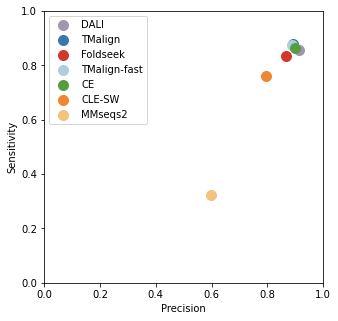

Name     	Sensitvity	Precision
----------------------------------------
DALI      	0.858		0.913
CE        	0.866		0.897
TMalign   	0.877		0.890
TMalign-fast	0.876		0.889
Foldseek  	0.833		0.868
CLE-SW    	0.759		0.794
MMseqs2   	0.325		0.597


In [196]:
#tools = [('Dali', res_dali), ('TM-align', res_tm), ('Foldseek', res_fs),  ('TM-align fast', res_tmfast), 
#         ('CE', res_ce), ('CLE-SW', res_cle), ('MMseqs2', res_mmseqs)]
colors = {"DALI":"#A495AF","TMalign":"#3B76AF","Foldseek":"#D1382C","TMalign-fast":"#ADCDE1",
          "CE":"#559E3E","CLE-SW":"#EE8632","3D-BLAST":"#643F95","MMseqs2":"#F4C27B"}
lines = []
csv_lines = []
plt.figure(figsize=(5,5))
for name, res in tools:
    # found, sens, prec = stats(list(filter(lambda fam_record: fam_record[4] in common_families, res)))  # filter subset
    found, sens, prec = stats(res)
    lines.append(f'{name:<10}\t{sens:.3f}\t\t{prec:.3f}')
    csv_lines.append([name, sens, prec])
    plt.scatter([prec], [sens], label=name, color=colors[name],s=100)

# Plot
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Sensitivity')
plt.xlabel('Precision')
plt.legend()
plt.savefig('out/plot.jpg', dpi=400)
plt.show()

# Print
print('Name     \tSensitvity\tPrecision')
print('-' * 40)
print('\n'.join(sorted(lines, key=lambda x: x.split()[2], reverse=True)))

# Export CSV
with open('out/homstrad_average.csv', 'w') as file:
    file.write('TOOL,SENSITIVITY,PRECISION\n')
    file.writelines(','.join([str(i) for i in line]) + '\n' for line in csv_lines)

## List all results

In [221]:
l = []
for i in range(len(tools[0][1])):
    name1, name2, sens, prec, fam_name, _ = tools[0][1][i]
    line = [fam_name, name1, name2, sens, prec]
    for name, res in tools[1:]:
        _name1, _name2, sens, prec, _fam_name, _ = res[i]
        assert name1 == _name1
        assert name2 == _name2
        assert fam_name == _fam_name
        line += [sens, prec]    
            
    line = '\t'.join([f'{line[0]:<20}'] + line[1:2] + [f'{val:.3f}' if val is not None else '-' for val in line[3:]])
    l.append(line)
l = sorted(l, key=lambda x: x.split()[0].lower())
#print('\n'.join(l))

## Export alignments

In [212]:
tool2fam2res = {name: {line[4]: line for line in res} for name, res in tools}

WIDTH = 80
def print_alignment(fam, first, last, tool, sens, prec, aln):
    if aln is not None:
        start1, aln1, start2, aln2 = aln
        lines.append(f'>{fam} {first} {last} {tool} sensitvity: {sens:.3f} precision: {prec:.3f}\n\n')
        while aln1:
            lines.append(f'{first:<6} {start1+1:>5} {aln1[:WIDTH]}\n')
            lines.append(f'{last:<6} {start2+1:>5} {aln2[:WIDTH]}\n')
            lines.append('\n')
            aln1 = aln1[WIDTH:]
            aln2 = aln2[WIDTH:]
            start1 += WIDTH
            start2 += WIDTH
    else:
        lines.append(f'>{fam} {first} {last} {tool} sensitvity: 0 precision: -\n')    

lines = []
for fam in sorted(os.listdir('homstrad_db/'), key=lambda x: x.lower()):
    ref_aln = parse_homstrad_ali(f'homstrad_db/{fam}/{fam}.ali')
    first, ref_aln1 = ref_aln[0]
    last, ref_aln2 = ref_aln[-1]
    print_alignment(fam, first, last, 'HOMSTRAD', 1, 1, (0, ref_aln1, 0, ref_aln2))
    for name, _ in tools:
        first, last, sens, prec, _, aln = tool2fam2res[name][fam]     
        print_alignment(fam, first, last, name, sens, prec, aln)
    lines.append('\n')

with open('out/alignments.txt', 'w') as file:
    file.writelines(lines)

## All tools fails here

In [33]:
lookup = {}
for tool_name, res in tools:
    for _, _, sens, _, fam in res:
        if fam not in lookup:
            lookup[fam] = {}
        lookup[fam][tool_name] = sens
        
for fam in lookup:
    if len([i for i in lookup[fam].values() if i is not None and i > 0]) == 0:
        print(fam, lookup[fam])

hexapep {'Foldseek': 0.0, 'TM-align': 0.0, 'TM-align fast': 0.0, 'Dali': 0.0, 'CE': 0.0, 'CLE-SW': 0.0, 'MMseqs2': 0.0}
PARATHYROID {'Foldseek': 0.0, 'TM-align': 0.0, 'TM-align fast': 0.0, 'Dali': None, 'CE': 0.0, 'CLE-SW': 0.0, 'MMseqs2': 0.0}
fusion_gly {'Foldseek': 0.0, 'TM-align': 0.0, 'TM-align fast': 0.0, 'Dali': 0.0, 'CE': 0.0, 'CLE-SW': 0.0, 'MMseqs2': 0.0}
TPR {'Foldseek': 0.0, 'TM-align': 0.0, 'TM-align fast': 0.0, 'Dali': 0.0, 'CE': 0.0, 'CLE-SW': 0.0, 'MMseqs2': 0.0}
LRR {'Foldseek': 0.0, 'TM-align': 0.0, 'TM-align fast': 0.0, 'Dali': 0.0, 'CE': 0.0, 'CLE-SW': 0.0, 'MMseqs2': 0.0}


## Outliers

In [34]:
tmscores = !cat out/pdbs/*/tmalignfast_tmp/tmalign.out | awk '/TM-score=.*Chain_1/{print $2}'

In [35]:
sens = !cat out/pdbs/*/tmalignfast.aln.log | awk '/^>/ {print $6}'

In [36]:
fams = !ls -l out/pdbs/*/tmalignfast.aln.log

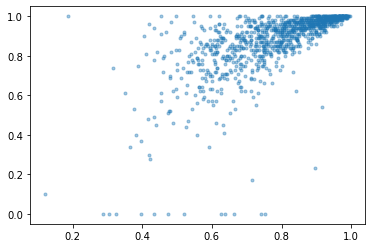

In [37]:
plt.scatter([float(i) for i in tmscores], [float(i[:-1]) for i in sens], marker='.', alpha=0.4)
plt.show()